In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

#Importing the data
df_credit =  pd.read_csv('drive/MyDrive/Colab_Notebooks/german_credit_data.csv',index_col=0)
print(df_credit.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB
None


In [7]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)

df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [9]:
#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [10]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [11]:
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])


In [12]:
df_credit[:5]

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Sex_male,Housing_own,Housing_rent,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Risk_bad,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,67,2,7.063904,6,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
1,22,2,8.691315,48,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
2,49,1,7.647786,12,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0
3,45,2,8.972337,42,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,53,2,8.490849,24,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [13]:
df_credit.columns[22:25]

Index(['Age_cat_Young', 'Age_cat_Adult', 'Age_cat_Senior'], dtype='object')

In [14]:
#Creating the X and y variables
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [15]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import f1_score

In [16]:
#Seting the Hyper Parameters
param_test1 = {
 'max_depth':[3,5,6,10],
 'min_child_weight':[3,5,10],
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10],
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

#Creating the classifier
model_xg = XGBClassifier(random_state=2)

grid_search = GridSearchCV(model_xg, param_grid=param_test1, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=2, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 6, 10],

In [17]:
y_pred = grid_search.predict(X_test)

# Verificaar os resultados obtidos
print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

0.756


[[157  21]
 [ 40  32]]


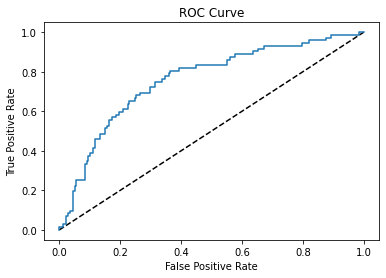

In [18]:
y_pred_prob = grid_search.predict_proba(X_test)[:,1]
fpr, tpr,thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [19]:
metrics.auc(fpr, tpr)

0.7576466916354556

In [62]:
orig_f1= f1_score(y_test,y_pred)

In [ ]:
##### Evaluate Fairness

In [21]:
### Anti-classification
print(X_test.shape, y_pred.shape)

(250, 24) (250,)


In [22]:
# Sex_Male: Column 11
Male_test = X_test[X_test[:,11]==1]
Female_test = X_test[X_test[:,11]==0]
print(Male_test.shape[0]+Female_test.shape[0])

250


In [23]:
Male_orig_pred = grid_search.predict(Male_test)
Female_orig_pred = grid_search.predict(Female_test)

In [24]:
# Flip Sex and predict label
Male_test[:,11]=0
Female_test[:,11]=1
Male_flipped_pred = grid_search.predict(Male_test)
Female_flipped_pred = grid_search.predict(Female_test)

In [25]:
np.sum(Male_orig_pred == Male_flipped_pred)/Male_orig_pred.shape[0]

0.96045197740113

In [26]:
np.sum(Female_orig_pred == Female_flipped_pred)/Female_orig_pred.shape[0]

0.9178082191780822

In [ ]:
np.sum(np.hstack([Male_orig_pred,Female_orig_pred])==np.hstack([Male_flipped_pred,Female_flipped_pred]))/(Male_orig_pred.shape[0]+Female_orig_pred.shape[0])

0.948

In [27]:
# Age column 21:24 Index(['Age_cat_Young', 'Age_cat_Adult', 'Age_cat_Senior'], dtype='object')
young_test = X_test[X_test[:,21]==1]
adult_test = X_test[X_test[:,22]==1]
senior_test = X_test[X_test[:,23]==1]
student_test = X_test[np.argwhere((X_test[:,21]==0) & (X_test[:,22]==0) & (X_test[:,23]==0)).flatten()]

In [28]:
young_orig_pred = grid_search.predict(young_test)
adult_orig_pred = grid_search.predict(adult_test)
senior_orig_pred = grid_search.predict(senior_test)
student_orig_pred = grid_search.predict(student_test)

In [29]:
young_test[:,21]=0
adult_test[:,22]=0
senior_test[:,23]=0
student_test[:,[21,22,23]]=0
young_flip_pred = grid_search.predict(young_test)
adult_flip_pred = grid_search.predict(adult_test)
senior_flip_pred = grid_search.predict(senior_test)
student_flip_pred = grid_search.predict(student_test)

In [30]:
np.sum(np.hstack([young_orig_pred,adult_orig_pred,senior_orig_pred,student_orig_pred])==np.hstack([young_flip_pred,adult_flip_pred,senior_flip_pred,student_flip_pred]))/X_test.shape[0]

0.976

In [ ]:
### Independence

In [31]:
# Sex Independence
prediction = grid_search.predict(X_test)

In [32]:
total_positive = np.sum((prediction ==1))
positive_female = np.sum((X_test[:,11]==0) * (prediction == 1))
positive_male = np.sum((X_test[:,11]==1) * (prediction == 1))
print(total_positive,  positive_female, positive_male)

53 19 34


In [33]:
print(Male_test.shape[0],Female_test.shape[0])

177 73


In [35]:
# 80% rule
(positive_female/total_positive)/(positive_male/total_positive)

0.5588235294117647

In [36]:
# Age Independence
positive_young = np.sum((X_test[:,21]==1) * (prediction == 1))

In [37]:
positive_adult = np.sum((X_test[:,22]==1) * (prediction == 1))
positive_senior = np.sum((X_test[:,23]==1) * (prediction == 1))

In [38]:
(positive_adult/total_positive)/(positive_young/total_positive) 

0.6190476190476191

In [39]:
(positive_senior/total_positive)/(positive_young/total_positive) 

0.09523809523809523

In [41]:
((total_positive-positive_young-positive_adult-positive_senior)/total_positive)/(positive_young/total_positive)

0.8095238095238094

In [ ]:
### Separation

In [42]:
# Sex
Male_idx = np.argwhere(X_test[:,11]==1)
Female_idx  = np.argwhere(X_test[:,11]==0)

In [44]:
Male_ytest = y_test[Male_idx].flatten()
Female_ytest = y_test[Female_idx].flatten()

In [45]:
Male_ypred = grid_search.predict(Male_test)
M_c = confusion_matrix(Male_ytest, Male_ypred)
M_c

array([[111,  16],
       [ 25,  25]])

In [46]:
Female_ypred = grid_search.predict(Female_test)
F_c = confusion_matrix(Female_ytest, Female_ypred)
F_c

array([[43,  8],
       [13,  9]])

In [47]:
# False negative rate.    supposed to be positive but not...
M_FNR = M_c[1,0]/(M_c[1,0]+M_c[1,1])
F_FNR = F_c[1,0]/(F_c[1,0]+F_c[1,1])
print(M_FNR, F_FNR)

0.5 0.5909090909090909


In [48]:
# Age 
young_idx = np.argwhere(X_test[:,21]==1)
adult_idx = np.argwhere(X_test[:,22]==1)
senior_idx = np.argwhere(X_test[:,23]==1)
student_idx = np.argwhere((X_test[:,21]==0) & (X_test[:,22]==0) & (X_test[:,23]==0))
young_ytest = y_test[young_idx].flatten()
adult_ytest = y_test[adult_idx].flatten() 
senior_ytest = y_test[senior_idx].flatten()
student_ytest =y_test[student_idx].flatten()
print(young_ytest.shape[0]+adult_ytest.shape[0]+senior_ytest.shape[0]+student_ytest.shape[0])

250


In [49]:
young_c = confusion_matrix(young_ytest,young_orig_pred)
adult_c = confusion_matrix(adult_ytest,adult_orig_pred)
senior_c = confusion_matrix(senior_ytest,senior_orig_pred)
student_c = confusion_matrix(student_ytest,grid_search.predict(X_test[student_idx.flatten()]))

In [50]:
def FNR(cm):
  return cm[1,0]/(cm[1,0]+cm[1,1])

In [51]:
print(FNR(young_c), FNR(adult_c), FNR(senior_c), FNR(student_c))

0.6 0.6 0.8 0.35294117647058826


In [ ]:
# Improve anticlassification

In [53]:
X_train_improved = np.delete(X_train,11,1)
X_test_improved = np.delete(X_test,11,1)
X_train_improved.shape

(750, 23)

In [52]:
grid_search.best_params_

{'colsample_bytree': 0.75,
 'gamma': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'subsample': 0.85}

In [54]:
model_xg_improve = XGBClassifier(random_state=2,max_depth=10,colsample_bytree=0.75,gamma=0.1,min_child_weight=3,subsample=0.85)
model_xg_improve.fit(X_train_improved, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [55]:
y_pred_imp = model_xg_improve.predict(X_test_improved)
print(accuracy_score(y_test,y_pred_imp))
print("\n")
print(confusion_matrix(y_test, y_pred_imp))

0.768


[[161  17]
 [ 41  31]]


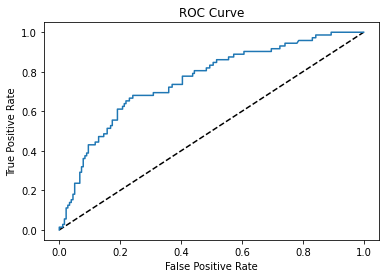

In [56]:
y_pred_prob = model_xg_improve.predict_proba(X_test_improved)[:,1]
fpr, tpr,thresholds = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [57]:
metrics.auc(fpr, tpr)

0.7553448813982523

In [ ]:
np.sum(y)

300

In [ ]:
y.shape[0]-np.sum(y)

700.0

In [ ]:
thresholds

array([1.970545  , 0.9705451 , 0.94185287, 0.94123316, 0.9357126 ,
       0.9230051 , 0.90412456, 0.8550583 , 0.85253423, 0.84555334,
       0.81606656, 0.802389  , 0.7956115 , 0.79075193, 0.7620288 ,
       0.7284179 , 0.7236028 , 0.6965498 , 0.65769666, 0.6010476 ,
       0.59987396, 0.59157807, 0.5654473 , 0.5511248 , 0.54402375,
       0.5370615 , 0.5312287 , 0.52314144, 0.51734525, 0.50183403,
       0.49278384, 0.48536432, 0.4819062 , 0.47792318, 0.44867486,
       0.44561523, 0.4365127 , 0.41523603, 0.41018733, 0.3929426 ,
       0.391572  , 0.38316625, 0.36002615, 0.33508995, 0.32293448,
       0.3198641 , 0.3121668 , 0.30765682, 0.29785305, 0.29443473,
       0.29259354, 0.2855525 , 0.27571708, 0.27136   , 0.22189254,
       0.21562958, 0.1862022 , 0.17646322, 0.17301823, 0.17253909,
       0.1632855 , 0.16057819, 0.1408955 , 0.13924168, 0.13779129,
       0.1350794 , 0.11124785, 0.11009524, 0.10854986, 0.10467137,
       0.09660263, 0.09598185, 0.09452936, 0.09223706, 0.08817

In [ ]:
### Improve Independence

In [58]:
threshold_male = np.arange(0,1,0.01)
threshold_female = np.arange(0,1,0.01)

In [59]:
threshold_male.shape

(100,)

In [60]:
np.hstack([threshold_female,threshold_male]).shape

(200,)

In [61]:
male_prob = grid_search.predict_proba(Male_test)
female_prob = grid_search.predict_proba(Female_test)
print('right ', len(male_prob)+len(female_prob))
acc = 0
m_th=0
f_th=0
perc = 0
for i in range(len(threshold_female)):
  for j in range(len(threshold_male)):
    male_pred = (male_prob[:,1] >= threshold_male[j]).astype('int')
    female_pred = (female_prob[:,1] >= threshold_female[i]).astype('int')
    positive_female = np.sum((female_pred == 1))
    positive_male = np.sum((male_pred == 1)) 
    fr = positive_male/Female_test.shape[0]
    mr = positive_female/Male_test.shape[0]
    test= np.hstack([Male_ytest,Female_ytest])
    pred = np.hstack([male_pred, female_pred])
    
    if fr>mr:
      if mr/fr >0.8:
        if accuracy_score(test,pred)>acc:
          acc = accuracy_score(test,pred)
          m_th=threshold_male[j]
          f_th = threshold_female[i]
          perc = mr/fr
    else:
      if fr/mr >0.8:
        if accuracy_score(test,pred)>acc:
          acc = accuracy_score(test,pred)
          m_th=threshold_male[j]
          f_th = threshold_female[i]
          perc = fr/mr
print(m_th,f_th,perc,acc)

right  250
0.76 0.25 0.854317998385795 0.74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
### Improve Separation

In [65]:
m_th = 0 
f_th = 0
FNR_f = 0
acc= 0
for i in range(len(threshold_female)):
  for j in range(len(threshold_male)):
    male_pred = (male_prob[:,1] >= threshold_male[j]).astype('int')
    female_pred = (female_prob[:,1] >= threshold_female[i]).astype('int')
    M_c = confusion_matrix(Male_ytest, male_pred)
    F_c = confusion_matrix(Female_ytest, female_pred)
    test= np.hstack([Male_ytest,Female_ytest])
    pred = np.hstack([male_pred, female_pred])
    M_FNR = FNR(M_c)
    F_FNR = FNR(F_c)
    # print(M_FNR, F_FNR)
    if M_FNR<F_FNR:
      if M_FNR/F_FNR>0.999 and (f1_score(test,pred)>orig_f1*0.8):
        m_th = threshold_male[j]
        f_th = threshold_female[i]
        FNR_f = M_FNR
        print(m_th, f_th, M_FNR,F_FNR,accuracy_score(test,pred),f1_score(test,pred))
    else:
      if F_FNR/M_FNR>0.999 and (f1_score(test,pred)>orig_f1*0.8):
          m_th = threshold_male[j]
          f_th = threshold_female[i]
          FNR_f = M_FNR
          print(m_th, f_th, M_FNR,F_FNR,accuracy_score(test,pred),f1_score(test,pred))
# print(m_th,f_th,FNR_f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


0.5 0.34 0.5 0.5 0.752 0.537313432835821
0.5 0.35000000000000003 0.5 0.5 0.752 0.537313432835821
0.5 0.36 0.5 0.5 0.752 0.537313432835821
0.5 0.37 0.5 0.5 0.752 0.537313432835821
0.5 0.38 0.5 0.5 0.752 0.537313432835821
0.5 0.39 0.5 0.5 0.752 0.537313432835821
0.5 0.4 0.5 0.5 0.752 0.537313432835821
0.5 0.41000000000000003 0.5 0.5 0.752 0.537313432835821
